# Workshop 2: Introduction to Hydrogen imports, Offshore Hubs & `Snakemake` workflows

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify snakemake
```
:::

In [1]:
# uncomment for running this notebook on Colab
# !pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify snakemake

In [2]:
from urllib.request import urlretrieve
import os
import zipfile

urls = {
    "data/data_raw.csv": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/data_raw.csv",
    "data/open-tyndp.zip": "https://storage.googleapis.com/open-tyndp-data-store/workshop-02/open-tyndp.zip",
}
for name, url in urls.items():
    if os.path.exists(name):
        print(f"File {name} already exists. Skipping download.")
    else:
        print(f"Retrieving {name} from GCP storage.")
        urlretrieve(url, name)

to_dir="data/open-tyndp"
if os.path.exists(to_dir):
    with zipfile.ZipFile("data/open-tyndp.zip", "r") as zip_ref:
        zip_ref.extractall(to_dir)
    print(f"Open-TYNDP available in '{to_dir}'.")

print("Done")

File data/data_raw.csv already exists. Skipping download.
File data/open-tyndp.zip already exists. Skipping download.
Done


## The `Snakemake` tool

<img src="snakemake_logo.png" width="300px" />

The `Snakemake` workflow management system is a tool to create reproducible and scalable data analyses.
Workflows are described via a human readable, Python based language. They can be seamlessly scaled to server, cluster, grid and cloud environments, without the need to modify the workflow definition.

Snakemake follows the [GNU Make](https://www.gnu.org/software/make) paradigm: workflows are defined in terms of so-called `rules` that define how to create a set of output files from a set of input files. Dependencies between the rules are determined automatically, creating a DAG (directed acyclic graph) of jobs that can be automatically parallelized.

:::{note}
Documentation for this package is available at https://snakemake.readthedocs.io/. You can also check out a [slide deck Snakemake Tutorial](https://slides.com/johanneskoester/snakemake-tutorial) by Johannes Köster (2024).

Mölder, F., Jablonski, K.P., Letcher, B., Hall, M.B., Tomkins-Tinch, C.H., Sochat, V., Forster, J., Lee, S., Twardziok, S.O., Kanitz, A., Wilm, A., Holtgrewe, M., Rahmann, S., Nahnsen, S., Köster, J., 2021. Sustainable data analysis with Snakemake. F1000Res 10, 33.
:::


### A minimal Snakemake example

To check out how this looks in practice, we've prepared a minimal Snakemake example workflow that processes some data. The minimal workflow consists of the following rules:
- `retrieve_data`
- `build_data`
- `prepare_network`
- `solve_network`
- `plot_benchmark`
- `all`

<div style="text-align: center;">
<img src="minimal_workflow.png" width="400px" />
</div>

We will first need to load the raw data file used in this minimal example into our google drive:

#### The `Snakefile` and `rules`

The rules need to be defined in a so-called `Snakefile` that sits in the same directory as your current working directory. For our minimal example the `Snakefile` looks like this:

#### Calling a workflow

You can then execute the workflow by asking for the target file `data_sorted.csv` or any intermediate file:
```
snakemake data_sorted.csv
```

Alternatively you can also execute the workflow by calling the rule that produces those files:
```
snakemake sort_data
```

Or you can call the common rule `all` which can be used to execute the whole workflow. It takes the final workflow output as its input and thus requires all previous dependent rules to be run as well:
```
snakemake all
```

The `-n` flag executes a `dry-run`. It is recommended to always first execute a `dry-run` before the actual execution of the workflow. This simply prints out the DAG of the workflow to investigate.

Let's try this out and investigate the output:

In [3]:
! snakemake all -n

Restricted license - for non-production use only - expires 2026-11-23
host: oet
Building DAG of jobs...
Job stats:
job               count
--------------  -------
all                   1
plot_benchmark        1
total                 2


[Thu Oct  9 11:17:38 2025]
rule plot_benchmark:
    input: data/base_2030_solved.nc
    output: data/benchmark.pdf
    jobid: 6
    reason: Missing output files: data/benchmark.pdf
    wildcards: ext=pdf
    resources: tmpdir=<TBD>
[Thu Oct  9 11:17:38 2025]
rule all:
    input: data/benchmark.png, data/benchmark.pdf
    jobid: 0
    reason: Input files updated by another job: data/benchmark.pdf
    resources: tmpdir=<TBD>
Job stats:
job               count
--------------  -------
all                   1
plot_benchmark        1
total                 2

Reasons:
    (check individual jobs above for details)
    input files updated by another job:
        all
    output files have to be generated:
        plot_benchmark
This was a dry-run (flag -n). The o

#### Visualizing the `DAG` of a worflow

You can also visualize the `DAG` of jobs using the `--dag` flag and the Graphviz `dot` command. This will not run the workflow but only create the visualization:
```
snakemake all --dag | dot -Tsvg > dag.svg
```

In [5]:
! snakemake all --dag | sed -n "/digraph/,\$p" | dot -Tpng > dag.png

Building DAG of jobs...


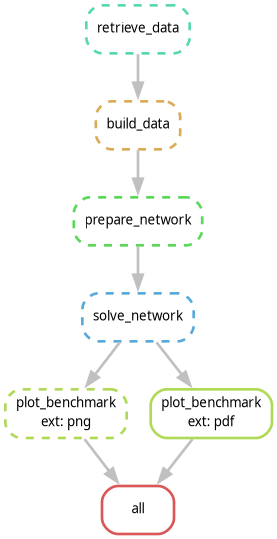

In [13]:
from IPython.display import SVG, Image, display
display(Image('dag.png'))

Alternatively, you can also visualize a filegraph like the figure above which includes also some information about the inputs and outputs to each of the rules.

You can reproduce the figure from above with the following command:
```
snakemake all --filegraph | dot -Tsvg > filegraph.svg
```

In [8]:
! snakemake all --filegraph | sed -n "/digraph/,\$p" | dot -Tsvg > filegraph.svg

Building DAG of jobs...


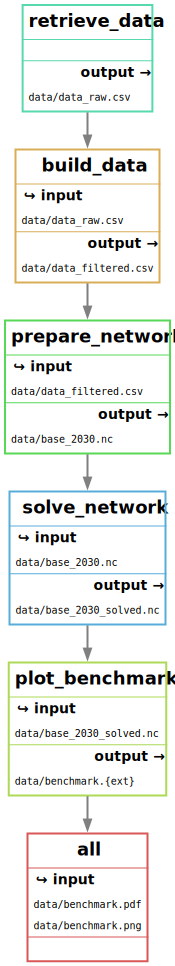

In [9]:
display(SVG('filegraph.svg'))

### Task 1: Executing a workflow with Snakemake

a) For our minimal example, execute a `dry-run` to produce the intermediate file `data_filtered.csv`.

b) Execute the workflow and investigate what happens if you try to execute the workflow again.

c) Delete the final output file `data_sorted.csv` and investigate what happens if you try to execute the workflow again.

d) Import the raw input data file `data_raw.csv` using pandas and save it again overwriting the original file. Investigate what happens if you try to execute the workflow again.

e ) FInally, open the `Snakefile` and add a second rule that filters the file `data_raw_2.csv` using the same script as the `filter_data` rule. Add the output of this new rule as a second input to the `sort_data` rule.

### Using Snakemake to launch the open-TYNDP workflow

Let's start by cloning the `open-tyndp` GitHub repository into our working directory...

We now need to change our working directory to this new directory:

In [7]:
import os

In [8]:
os.chdir('open-tyndp')

Let's check that we are indeed in the new directory now:

In [9]:
os.getcwd()

'/home/tgilon/Documents/oet/open-tyndp-workshops/open-tyndp-workshops/open-tyndp'

We can now use Snakemake to call some of the rules to produce outputs with the `open-tyndp` PyPSA model. 

We will use the test configuration file and schedule a dry-run with `-n` as we only want to investigate the DAG of the workflow:

In [10]:
! snakemake -call all --configfile config/test/config.tyndp.yaml -n

Restricted license - for non-production use only - expires 2026-11-23
host: oet
Building DAG of jobs...
Job stats:
job                                                 count
------------------------------------------------  -------
add_brownfield                                          2
add_electricity                                         1
add_existing_baseyear                                   1
add_transmission_projects_and_dlr                       1
all                                                     1
base_network                                            1
build_ammonia_production                                1
build_bidding_zones                                     1
build_biomass_potentials                                3
build_biomass_transport_costs                           1
build_central_heating_temperature_profiles              3
build_clustered_population_layouts                      1
build_clustered_solar_rooftop_potentials                1
build_cop_profi

:::{note}
If you are executing this notebook on your local machine, you can also use the `conda` package manager to install the `open-tyndp` environment and run the workflow instead of dry-runs:
```
conda env create --file envs/<YourSystemOS>-pinned.yaml
```
:::

### Task 2: Adjusting the Open-TYNDP workflow with the configuration file

a) Make some changes in the configuration file and call another **dry-run** of the `open-tyndp` model again to see the changes to the workflow.

## H2 imports

# Time Series

## Offshore Hubs

# Benchmarking framework